# TODO

### Operations
- Figure out the least amount of data that needs to be provided
- Save + load model and compare results
- Build API around it

### Features
- Add feature for days since last signal
- Add feature for number of signals last year
- Add feature based on output on news model


In [565]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:\dev\stocky-ml\credentials.json"

# Data:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dateutil.parser
import dateutil.tz as tz
from datetime import datetime, timedelta
import talib   
from talib import MA_Type


# Visualization:
import seaborn as sns

# Database:
from google.cloud import firestore

In [566]:
# Create db instance: 
db = firestore.Client()

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [567]:
def get_price_data(id):
    doc = db.collection('prices').document(id).get().to_dict()
    
    df = pd.DataFrame.from_dict(doc['priceData'])
    df = add_calculated_columns(df)
    df = convert_dates(df)

    # Read the file to lazily make sure that the dates are strings etc.
    # FIXME: Should probably be done some other way.
    # output.drop(columns=['Unnamed: 0'], inplace = True)
    return df

def get_trade_data(doc):
    doc = doc.to_dict()
    
    df = pd.DataFrame.from_dict(doc['trades'])
    df['result'] = (df['exitPrice'] / df['entryPrice']) -1
    df = convert_trade_dates(df)

    return df[['date', 'result']]

def convert_date(date, fmt = "%Y-%m-%d", target_tz = tz.gettz('CET')):
    return date.replace(tzinfo=tz.gettz("UTC")).astimezone(target_tz).strftime(fmt)
    
def convert_dates(df):
    cet = tz.gettz('CET')
    for i, row in df.iterrows():
        d = convert_date(dateutil.parser.isoparse(row['date']))
        df.at[i,'date'] = d
    return df

def convert_trade_dates(df):
    cet = tz.gettz('CET')
    for i, row in df.iterrows():
        d = convert_date(row['entryDate'] - timedelta(days=1)) # Want one day earlier so that we don't have look ahead
        df.at[i,'date'] = d
    return df

def add_calculated_columns(price):
    lookbacks = [20, 50, 100, 200]
    values = ['close', 'volume']
        
    for value in values:
        for lookback in lookbacks:
            # Get the rolling average and std:
            price['average'] = price[value].rolling(lookback).mean()
            price['std'] = price[value].rolling(lookback).std()
            high = price['high'].rolling(lookback).max()
            low = price['low'].rolling(lookback).min()
            

            # Normalize distance to mean. This could be done with the data above but dont know how.
            price[f'zs-{lookback}-{value}'] = (price[value] - price['average']) / price['std']

            # Get slope of rolling average and std
            price[f'ma-slope-{lookback}-{value}'] = price['average'] / price['average'].shift(1)
            price[f'std-slope-{lookback}-{value}'] = price['std'] / price['std'].shift(1)

            # Get range
            price[f'rng-{lookback}'] = high / low
            price[f'percent-rng-{lookback}-{value}'] = (high / low) / price[value]
            price[f'percent-std-{lookback}-{value}'] = price['std'] / price[value]

            if value == 'volume':
                price['temp_volume'] = round(price['volume'] * (price['close'] * 2 + price['open'] * 2 + price['low'] + price['high'])/6)
                price[f'avg-log-volume-{lookback}'] = np.log10(price['temp_volume'])  
                price.drop(columns=['temp_volume'], inplace = True)



            # Drop the actual values since they carry no interest:
            price.drop(columns=['average', 'std'], inplace = True)
            
        # TODO: Add calculations for volume
        # TODO: Add calculations for owners
    return price

In [568]:
def merge_index_stock_df(omxdf, stockdf):
  df = stockdf.copy()
  df['omx_close'] = omxdf['close']
  df['stock_close'] = stockdf['close']

  df = df[df['stock_close'].notna()]
  df['volume'] = stockdf['volume']


  df['stock_zs-50-close'] = stockdf['zs-50-close']
  df['stock_zs-100-close'] = stockdf['zs-100-close']
  df['stock_zs-200-close'] = stockdf['zs-200-close']
  df['stock_quota'] = df['stock_close']/df['omx_close']


  df['stock_hist_relative_perf20'] = df['stock_quota'].shift(20) / df['stock_quota']
  df['stock_hist_relative_perf50'] = df['stock_quota'].shift(50) / df['stock_quota']
  df['stock_hist_relative_perf100'] = df['stock_quota'].shift(100) / df['stock_quota']

  df['stock_hist_perf20'] = df['stock_close'].shift(20) / df['stock_close']
  df['stock_hist_perf50'] = df['stock_close'].shift(50) / df['stock_close']
  df['stock_hist_perf100'] = df['stock_close'].shift(100) / df['stock_close']

  for p in [8, 20, 34, 50, 100]:
    df[f'stock_relative_rsi_{p}'] = talib.RSI(df['stock_quota'], timeperiod=p) /100
    df[f'stock_rsi_{p}'] = talib.RSI(df['stock_close'], timeperiod=p) / 100


  return df

In [569]:
# Load the omx price data
omxdf = get_price_data('19002')


In [570]:
df = pd.DataFrame()

try: 
  df = pd.read_csv('stockytrades.csv')
except:
  print('Failed to read file')
  docs = db.collection('trades').stream()

  for doc in docs:
    print('starting', doc.id)
    stockdf = get_price_data(doc.id)
    tradedf =  get_trade_data(doc)
    merged_df = pd.merge(stockdf, omxdf, on='date', suffixes=('_stock', '_omx'))

    
    merged_df = pd.merge(merged_df, tradedf, on='date', suffixes=('_1', '_2'))
    merged_df.drop(columns=['owners'], inplace = True, errors='ignore')
    
    df = pd.concat([df, merged_df], ignore_index=True)
  
  # Save the file so we dont have to next time
  df.to_csv('stockytrades.csv')


df.head()


,Unnamed: 0,date,volume_stock,high_stock,low_stock,owners_stock,close_stock,open_stock,zs-20-close_stock,ma-slope-20-close_stock,std-slope-20-close_stock,rng-20_stock,percent-rng-20-close_stock,percent-std-20-close_stock,zs-50-close_stock,ma-slope-50-close_stock,std-slope-50-close_stock,rng-50_stock,percent-rng-50-close_stock,percent-std-50-close_stock,zs-100-close_stock,ma-slope-100-close_stock,std-slope-100-close_stock,rng-100_stock,percent-rng-100-close_stock,...,zs-20-volume_omx,ma-slope-20-volume_omx,std-slope-20-volume_omx,percent-rng-20-volume_omx,percent-std-20-volume_omx,avg-log-volume-20_omx,zs-50-volume_omx,ma-slope-50-volume_omx,std-slope-50-volume_omx,percent-rng-50-volume_omx,percent-std-50-volume_omx,avg-log-volume-50_omx,zs-100-volume_omx,ma-slope-100-volume_omx,std-slope-100-volume_omx,percent-rng-100-volume_omx,percent-std-100-volume_omx,avg-log-volume-100_omx,zs-200-volume_omx,ma-slope-200-volume_omx,std-slope-200-volume_omx,percent-rng-200-volume_omx,percent-std-200-volume_omx,avg-log-volume-200_omx,result
0,0,2019-11-11,937763.0,105.45,100.05,16786.0,104.80,100.55,2.406278,1.008411,1.206170,1.233333,0.011768,0.049977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.334595
1,1,2020-06-04,2167584.0,170.55,160.45,18567.0,169.90,160.75,2.570386,1.012324,1.023911,1.277528,0.007519,0.041544,2.138433,1.010411,1.007476,1.849783,0.010887,0.097403,2.087838,1.003921,1.019671,2.210915,0.013013,...,0.156139,1.009669,0.995888,1.114351e-08,0.302561,11.251926,-0.240291,0.983645,0.935139,1.267716e-08,0.303904,11.251926,-0.256563,0.997336,0.999528,1.438877e-08,0.450774,11.251926,NaN,NaN,NaN,1.438877e-08,NaN,11.251926,-0.134604
2,2,2020-07-06,908268.0,184.65,179.55,18595.0,184.45,180.00,2.339982,1.000686,1.031583,1.262564,0.006845,0.047219,2.121880,1.007725,1.012728,1.526664,0.008277,0.079306,1.999881,1.003812,1.019996,2.393700,0.012977,...,-1.021078,0.980999,1.023035,1.436401e-08,0.324498,11.121916,-0.961179,0.993908,1.009332,1.544756e-08,0.344210,11.121916,-0.920364,0.999753,1.000571,1.968961e-08,0.605698,11.121916,NaN,NaN,NaN,1.968961e-08,NaN,11.121916,-0.067935
3,3,2020-10-14,1479449.0,191.50,178.10,20927.0,188.90,178.10,1.817743,1.009085,1.050660,1.272425,0.006736,0.050375,0.618434,0.997120,0.968908,1.505648,0.007971,0.105323,0.539262,1.002220,0.992524,1.586279,0.008397,...,-0.291895,0.990344,0.996820,1.444031e-08,0.270197,11.128150,0.064049,1.004745,0.991875,1.470981e-08,0.238545,11.128150,-0.350554,0.997029,0.999035,1.619484e-08,0.365987,11.128150,-0.602651,1.00146,0.996767,2.069980e-08,0.572475,11.128150,0.282463
4,4,2021-03-30,659684.0,290.60,274.90,28485.0,283.70,276.40,2.180677,1.006883,1.156869,1.243475,0.004383,0.044750,1.856338,1.005233,0.983717,1.338377,0.004718,0.055730,1.829468,1.004957,1.003570,1.709517,0.006026,...,-0.927763,1.000411,0.996812,1.471851e-08,0.147023,11.207166,-0.554525,1.000018,0.999947,1.555449e-08,0.216722,11.207166,-0.387574,0.999153,1.000751,1.727156e-08,0.280320,11.207166,-0.307612,0.99760,0.994528,1.848767e-08,0.286702,11.207166,0.297843


In [571]:
# Drop problematic columns.
# TODO: See if you can improve the data quality to be able to use more of these
df.drop(columns=[
                'owners_stock', 
                'volume_omx',
                'owners_omx',
                'zs-20-volume_omx',
                'ma-slope-20-volume_omx',
                'std-slope-20-volume_omx',
                'percent-rng-20-volume_omx',
                'percent-std-20-volume_omx',
                'avg-log-volume-20_omx',
                'zs-50-volume_omx',
                'ma-slope-50-volume_omx',
                'std-slope-50-volume_omx',
                'percent-rng-50-volume_omx',
                'percent-std-50-volume_omx',
                'avg-log-volume-50_omx',
                'zs-100-volume_omx',
                'ma-slope-100-volume_omx',
                'std-slope-100-volume_omx',
                'percent-rng-100-volume_omx',
                'percent-std-100-volume_omx',
                'avg-log-volume-100_omx',
                'zs-200-volume_omx',
                'ma-slope-200-volume_omx',
                'std-slope-200-volume_omx',
                'percent-rng-200-volume_omx',
                'percent-std-200-volume_omx',
                'avg-log-volume-200_omx',
                'date',
                'zs-200-volume_stock',            
                'ma-slope-200-volume_stock',      
                'std-slope-200-volume_stock',     
                'percent-rng-200-volume_stock',  
                'percent-std-200-volume_stock',   
                'zs-100-volume_stock',            
                'ma-slope-100-volume_stock',      
                'std-slope-100-volume_stock',     
                'percent-rng-100-volume_stock',   
                'percent-std-100-volume_stock',   
                ], inplace=True, errors='ignore')

len(df)

20323

In [572]:
df.isna().sum()

Unnamed: 0                        0
volume_stock                     21
high_stock                        0
low_stock                         0
close_stock                       0
open_stock                        0
zs-20-close_stock               351
ma-slope-20-close_stock         361
std-slope-20-close_stock        370
rng-20_stock                    351
percent-rng-20-close_stock      351
percent-std-20-close_stock      351
zs-50-close_stock               724
ma-slope-50-close_stock         736
std-slope-50-close_stock        736
rng-50_stock                    724
percent-rng-50-close_stock      724
percent-std-50-close_stock      724
zs-100-close_stock             1259
ma-slope-100-close_stock       1271
std-slope-100-close_stock      1271
rng-100_stock                  1259
percent-rng-100-close_stock    1259
percent-std-100-close_stock    1259
zs-200-close_stock             2321
ma-slope-200-close_stock       2331
std-slope-200-close_stock      2332
rng-200_stock               

In [573]:
# Clean the data that cannot be used for training
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("Total number of trades:", len(df))


# Add the label we want to predict
df['label'] = np.where(df['result'] > 0, 1, 0)

Total number of trades: 17403


0.036230354368728006 89.56603773584905


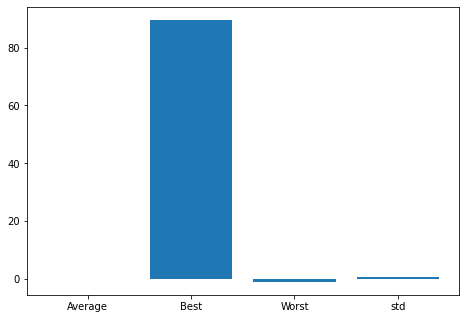

Average 3.6230354368728004%
Best 8956.603773584906%
Worst -98.48192771084338%
std 78.43640288073676%


In [574]:
#plot distribution of points by team 
avg = df['result'].mean()
best = df['result'].max()
worst = df['result'].min()
std = df['result'].std()

print(avg, best)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
stats = ['Average', 'Best', 'Worst', 'std']
columns = [avg, best, worst, std]
ax.bar(stats, columns)
plt.show()

for i in range(len(stats)):
  print(stats[i], f'{columns[i]*100}%')

### Machine learning part

- Drop all `NaN` values first. 
- Then split the dataset for test and training (using K-fold?). 
- Train the model
- Create a confusion matrix on the validation data. Compare results with reality



In [575]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix



In [576]:
# Shuffle the dataset
train_data, validation_data =  train_test_split(df, test_size=0.15, random_state=42) 

# Split the dataset into features and target
X = train_data.drop(columns=['result', 'label'], axis=1).values
y = train_data['label'].values


In [707]:
# K-fold
num_folds = 5
# Define the k-fold cross-validator
kfold = KFold(n_splits=num_folds)



In [708]:
# Normalize input data
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Define TensorFlow model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [709]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30)

# Define learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)

# Calculate class weights based on occurrence since the base strategy loses more often we want to equalize the weights
class_weights = compute_class_weight('balanced', np.unique(y), y)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

c:\Users\Bauhn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [710]:
# Train the model using k-fold cross-validation
for train_index, val_index in kfold.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Scale the data
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Train the model
    model.fit(X_train_fold_scaled, 
              y_train_fold, 
              epochs=1000, 
              batch_size=32, 
              validation_data=(X_val_fold_scaled, y_val_fold), 
              callbacks=[lr_scheduler, early_stopping],  
              class_weight=class_weights_dict 
            )

Epoch 1/1000
370/370 [==============================] - 2s 2ms/step - loss: 0.7298 - accuracy: 0.5393 - val_loss: 0.6832 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 2/1000
370/370 [==============================] - 1s 2ms/step - loss: 0.6827 - accuracy: 0.5735 - val_loss: 0.6699 - val_accuracy: 0.5945 - lr: 0.0010
Epoch 3/1000
370/370 [==============================] - 1s 2ms/step - loss: 0.6767 - accuracy: 0.5857 - val_loss: 0.6640 - val_accuracy: 0.6134 - lr: 0.0010
Epoch 4/1000
370/370 [==============================] - 1s 2ms/step - loss: 0.6701 - accuracy: 0.6019 - val_loss: 0.6689 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 5/1000
370/370 [==============================] - 1s 2ms/step - loss: 0.6670 - accuracy: 0.6091 - val_loss: 0.6612 - val_accuracy: 0.6171 - lr: 0.0010
Epoch 6/1000
370/370 [==============================] - 1s 2ms/step - loss: 0.6627 - accuracy: 0.6130 - val_loss: 0.6667 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 7/1000
370/370 [==============================] - 1s

In [711]:

# Scale the validation data with the same scaler used for the training data
validation_x = scaler.fit_transform(validation_data.drop(columns=['result', 'label'], axis=1).values)

# Run predictions on the validation dataset
y_pred = model.predict(validation_x)


In [712]:
tn, fp, fn, tp = confusion_matrix(validation_data['label'], np.where(y_pred > 0.5, 1, 0).flatten()).ravel()

accuracy = (tp+tn) / (tp+tn+fn+fp)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision*recall)/(precision+recall)

print(f'accuracy: {accuracy} - precision: {precision} - recall: {recall} - f1 {f1}')

accuracy: 0.6238988893144389 - precision: 0.4930232558139535 - recall: 0.5480868665977249 - f1 0.5190989226248776


In [713]:
def summarize(df, name):
    winners = df[df['result'] >= 0]
    losers = df[df['result'] < 0]
    
    return pd.DataFrame.from_dict({
        'count': len(df),
        'avg': df['result'].mean(),
        'winrate': len(winners) / len(df),
        'avg_winner': winners['result'].mean(),
        'avg_loser': losers['result'].mean(),
        'total_win': winners['result'].sum(),
        'total_loss':  losers['result'].sum(),
        'profit_factor': winners['result'].sum() / -losers['result'].sum()
    }, orient='index', columns=[name])


In [714]:
res = validation_data[['result', 'label']].copy()
res['pred'] = y_pred

threshold = 0.5

all_trades = summarize(res, "all")
pred_winners = summarize(res[res['pred'] >= threshold], "predicted winners")
pred_losers = summarize(res[res['pred'] < threshold], "predicted losers")


pd.concat([all_trades, pred_winners, pred_losers,], axis=1)

,all,predicted winners,predicted losers
count,2611.000000,1075.000000,1536.000000
avg,0.048369,0.130555,-0.009150
winrate,0.387591,0.505116,0.305339
avg_winner,0.328885,0.370692,0.280481
avg_loser,-0.129168,-0.114547,-0.136457
total_win,332.831466,201.285968,131.545498
total_loss,-206.538871,-60.939099,-145.599772
profit_factor,1.611471,3.303068,0.903473


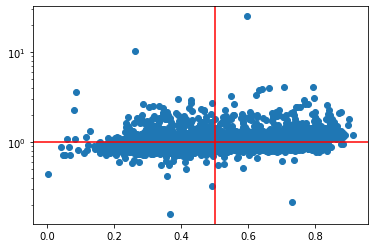

In [715]:
fig, ax = plt.subplots()
ax.scatter( res['pred'], res['result'] +1)
ax.set_yscale("log");
# ax.set_xscale("log");
# All above 1 is winners
plt.axhline(y=1, color='r', linestyle='-')
# All above threshold is predicted to be winners
plt.axvline(x=threshold, color='r', linestyle='-')
plt.show()

In [716]:
def divide(a, b):
    return b and a / b or 0

def getStats(inrange):
    winners = inrange[inrange['result'] >= 0]
    losers = inrange[inrange['result'] <= 0]
        
    d = {
        'winrate': divide(len(winners),len(inrange)),
        'profit_factor': divide(winners['result'].sum(), -losers['result'].sum())
    }
    return d

percentiles = []
winrates_above = []
profitfactors_above = []
winrates_below = []
profitfactors_below = []

for i in range(10):
    percentiles.append(i*10)

    # Probability Above i/10
    above = getStats(res[res['pred'] >= i/10])
    winrates_above.append(above['winrate'])
    profitfactors_above.append(above['profit_factor'])

    # Probability below i/10
    below = getStats(res[res['pred'] < i/10])
    winrates_below.append(below['winrate'])
    profitfactors_below.append(below['profit_factor'])


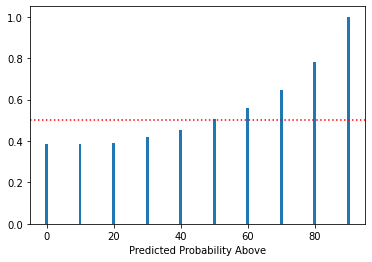

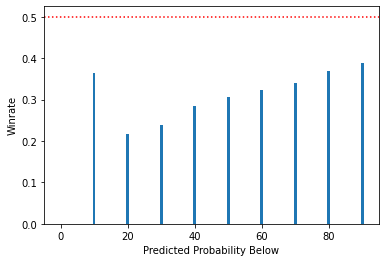

In [717]:
fig, ax1 = plt.subplots()
ax1.bar( percentiles, winrates_above)
plt.axhline(y=0.5, color='r', linestyle=':')
plt.xlabel('Predicted Probability Above')
fig2, ax2 = plt.subplots()
ax2.bar( percentiles, winrates_below)
plt.axhline(y=0.5, color='r', linestyle=':')
plt.xlabel('Predicted Probability Below')
plt.ylabel('Winrate')
plt.show()

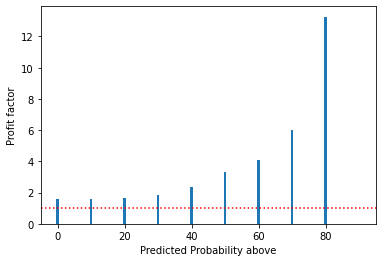

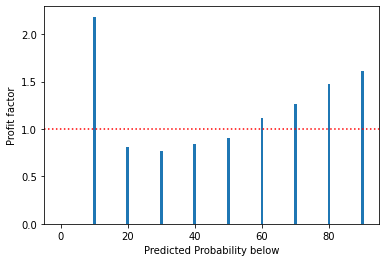

In [718]:
fig, ax = plt.subplots()
ax.bar( percentiles, profitfactors_above)
plt.axhline(y=1, color='r', linestyle=':')
plt.xlabel('Predicted Probability above')
plt.ylabel('Profit factor')

fig, ax2 = plt.subplots()
ax2.bar( percentiles, profitfactors_below)
plt.axhline(y=1, color='r', linestyle=':')
plt.xlabel('Predicted Probability below')
plt.ylabel('Profit factor')
plt.show()